Before starting, let's import some RooFit stuff.

In [1]:
from ROOT import RooGaussian
from ROOT import RooExponential
from ROOT import RooProdPdf
from ROOT import RooExtendPdf
from ROOT import RooFit
from ROOT import RooRealVar
from ROOT import RooAddPdf
from ROOT import RooArgList
from ROOT import RooArgSet
import ROOT
ROOT.SetMemoryPolicy(ROOT.kMemoryStrict)
import ROOT

def destruct_object(object_):
    """Destruct an object inheriting from TObject.

    See http://root.cern.ch/download/doc/ROOTUsersGuideHTML/ch19.html#d5e27551
    for more details

    provided by @apuignav

    :param object_: object to delete
    :type object_: TObject

    """
    if issubclass(type(object_), ROOT.TObject):
        object_.IsA().Destructor(object_)

Welcome to JupyROOT 6.07/03


Set up matplotlib for additional drawings. [See this blog for further information](http://jakevdp.github.io/blog/2013/07/10/XKCD-plots-in-matplotlib/).

In [2]:
%pylab inline
plt.xkcd()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# per event observables
bdt      = RooRealVar("BDT","some awesome BDT",0.,1.)
mass     = RooRealVar("mass","invariant mass",5100.,5300,"MeV/c^{2}")
time     = RooRealVar("time","decay time",0.,10,"ps")

# lifetime of B mesons (first for event generation, later for fitting)
time_central = -1./1.519
time_min     = -1./0.200
time_max     = -1./9.200
blifetime= RooRealVar("blifetime","B meson lifetime",time_central,time_min,time_max)

# yield parameters
sy_start = 100.
sy_min = 0.
sy_max = 100000.
sigyield = RooRealVar("sigyield","signal yield",sy_start,sy_min,sy_max)
by_start = 900.
by_min = 0.
by_max = 100000.
bkgyield = RooRealVar("bkgyield","background yield",by_start,by_min,by_max)

#### PDFs ####
# signal PDF in mass x time x BDT
bmassPDF = RooGaussian("bmass","B mass shape",mass,RooFit.RooConst(5200.),RooFit.RooConst(20.))
btimePDF = RooExponential("btime","B time shape",time,blifetime)
bdtsPDF  = RooExponential("bdts","sig bdt shape",bdt,RooFit.RooConst(0.))

# extended mass pdf for fit (signal)
EmsigPDF = RooExtendPdf("Emsigpdf","extended signal mass pdf",bmassPDF,sigyield)

# product of all three dimensions for generation (signal)
sigPDF   = RooProdPdf("sigpdf","signal pdf",RooArgList(bmassPDF,bdtsPDF,btimePDF))
EsigPDF  = RooExtendPdf("Esigpdf","extended signal pdf",sigPDF,sigyield)

# product of mass and time for 2D fit (signal)
sigfitpdf= RooProdPdf("sigfitpdf","signal fit pdf",bmassPDF,btimePDF)
Esigfitpdf=RooExtendPdf("Esigfitpdf","extended signal fit pdf",sigfitpdf,sigyield)



# background PDF in mass x time x BDT
bkgmPDF  = RooExponential("bkgmass","bkg mass shape",mass,RooFit.RooConst(-1./200.))
bkgtPDF  = RooExponential("bbktime","bkg time shape",time,RooFit.RooConst(-1./0.200))
bdtbPDF  = RooExponential("bdtb","bkg bdt shape",bdt,RooFit.RooConst(-3.))

# extended mass pdf for fit (background)
EmbkgPDF = RooExtendPdf("Embkgpdf","extended background mass pdf",bkgmPDF,bkgyield)

# product of all three dimensions for generation (background)
bkgPDF   = RooProdPdf("bkgpdf","background pdf",RooArgList(bkgmPDF,bdtbPDF,bkgtPDF))
EbkgPDF  = RooExtendPdf("Ebkgpdf","extended background pdf",bkgPDF,bkgyield)

# product of mass and time for 2D fit (background)
bkgfitpdf= RooProdPdf("bkgfitpdf","background fit pdf",bkgmPDF,bkgtPDF)
Ebkgfitpdf=RooExtendPdf("Ebkgfitpdf","extended background fit pdf",bkgfitpdf,bkgyield)



# sum for 1D mass pdfs for mass fit
combmPDF = RooAddPdf("fullmasspdf","full mass pdf",RooArgList(EmsigPDF,EmbkgPDF))

# sum for 2D pdfs (mass and time) for 2D fit
fitPDF   = RooAddPdf("fitpdf","mass and time pdf",RooArgList(Esigfitpdf,Ebkgfitpdf))

# sum for 3D pdfs for event generation
combPDF  = RooAddPdf("fullpdf","full pdf",RooArgList(EsigPDF,EbkgPDF))

The models I try to set up are a Gaussian mass peak for the signal and exponential background. In decay time the signal is long lived, the background short lived. In BDT, the signal is uniform, the background exponential.

Lets look at a small toy where a cut on the BDT cleans up the decay time spectrum.

[#1] INFO:Plotting -- RooPlot::updateFitRangeNorm: New event count of 2129 will supercede previous event count of 10000 for normalization of PDF projections
10000.0
2129.0
sideband for cut at 0. 0 	 has entries: 4743.0
signal window    at 0. 0 	 has entries: 5257.0
signal           at 0. 0 	 has entries: 514.0
FoM              at 0. 0 	 has entries: 7.08914942474
sideband for cut at 0. 1 	 has entries: 3459.0
signal window    at 0. 1 	 has entries: 3977.0
signal           at 0. 1 	 has entries: 518.0
FoM              at 0. 1 	 has entries: 8.21394828581
sideband for cut at 0. 2 	 has entries: 2515.0
signal window    at 0. 2 	 has entries: 3058.0
signal           at 0. 2 	 has entries: 543.0
FoM              at 0. 2 	 has entries: 9.81931266651
sideband for cut at 0. 3 	 has entries: 1799.0
signal window    at 0. 3 	 has entries: 2311.0
signal           at 0. 3 	 has entries: 512.0
FoM              at 0. 3 	 has entries: 10.6504997922
sideband for cut at 0. 4 	 has entries: 1245.0
signa

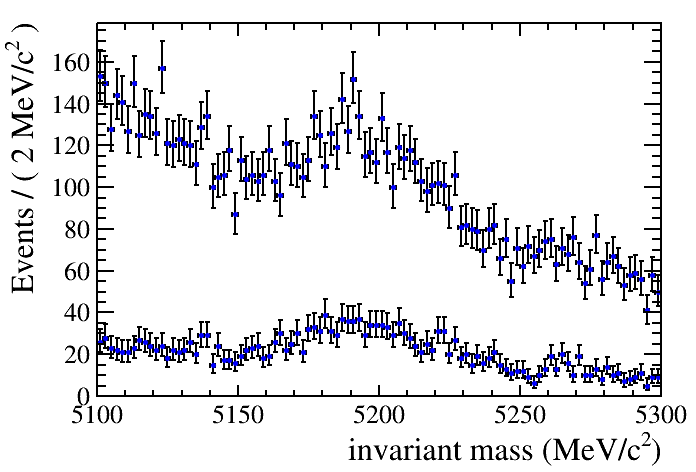

In [4]:
SIMEVTS = 10000#0
NTOYS = 1000
truesigyield = SIMEVTS*(sigyield.getVal()/(sigyield.getVal()+bkgyield.getVal()))
def gentoy():
    toydata = combPDF.generate(RooArgSet(bdt,mass,time),SIMEVTS)
    return toydata
toydata = gentoy()
from ROOT import TCanvas, RooCmdArg
from ROOT.RooFit import Cut
c = TCanvas()
frame = mass.frame()
toydata.plotOn(frame)
smalldata = toydata.reduce(Cut("BDT>0.5"))
smalldata.plotOn(frame)#,Cut("BDT>0.5"))
print toydata.sumEntries()
print toydata.sumEntries("BDT>0.5")
def FOM(data,cut,verbose):
    import math
    B = data.sumEntries("BDT>"+str(cut)+"&&(mass<5150||mass>5250)")
    SpB = data.sumEntries("BDT>"+str(cut)+"&&(mass>5150&&mass<5250)")
    S = SpB-B
    FOM = S/math.sqrt(S+B)
    if verbose:
        print "sideband for cut at 0.",i,"\t has entries:", B
        print "signal window    at 0.",i,"\t has entries:", SpB
        print "signal           at 0.",i,"\t has entries:", S
        print "FoM              at 0.",i,"\t has entries:", FOM
    return FOM
for i in range(10):
    FOM(toydata,i/10.,True)
frame.Draw()
#c.SetLogy()
c.Draw()
destruct_object(toydata)
destruct_object(smalldata)

For automisation, a few helper functions: resetting fit parameters, fitting the toy data (with possible cut on the BDT - the efficiency for the signal as function of cut value is perfectly known, as well as the true signal expected yield), determination of pull in yield and bias.

For each toy, a scan over BDT cut values is performed (in steps of 0.1) to pick the best cut value.
Commented out, this is the one with the smallest uncertainty on the signal yield, fitting the invariant mass distribution. Commented in, I just count the number of events in signal window and sideband region.

The full fit to determine the lifetime, is an sFit. This means, the invariant mass spectrum is fitted, then all non-yield parameters are fixed and the yields are fitted again. As function of the invariant mass (using the fitted mass pdfs, and the covariance matrix of the fitted yields) weights are assigned, which parametrise how likely an event is signal or background, such that effectively the sum of all weights for background events sum up to 0 (such that backgrounds don't have an effect on the next fit). The weighted decay time is then fitted with only the signal component of the decay time distribution.

Generally, people don't fully trust the error estimates of sFits and therefore recommend using the bootstrap method to estimate the statistical uncertainty of the fit result. I don't do that here as I claim this is not relevant in my toys. See below the lifetime pulls for the scenarios w/o cut and with fixed cut. The bias is much smaller than in the optimised fit scenario.

In [5]:
from ROOT import RooMsgService
RooMsgService.instance().setGlobalKillBelow(RooFit.WARNING)
def reset():
    bkgyield.setMin(by_min)
    bkgyield.setMin(by_min)
    bkgyield.setMax(by_max)
    bkgyield.setMax(by_max)
    bkgyield.setVal(by_start)
    sigyield.setMin(sy_min)
    sigyield.setMin(sy_min)
    sigyield.setMax(sy_max)
    sigyield.setMax(sy_max)
    sigyield.setVal(sy_start)
    blifetime.setVal(time_central)
    blifetime.setMin(time_min)
    blifetime.setMax(time_max)

to_be_deleted = []

def fitwithcut(dataset,cutvalue):
    global to_be_deleted
    #print "full fit"
    reset()
    smalldata = dataset.reduce(Cut("BDT>"+str(cutvalue)))
    #smalldata.Print("V")
    #print "fit mass"
    combmPDF.fitTo(smalldata,RooFit.Save(False),RooFit.NumCPU(3),RooFit.PrintLevel(-1000))
    from ROOT.RooStats import SPlot
    #print "call splot"
    splot = SPlot("splot","splot",smalldata,combmPDF,RooArgList(sigyield,bkgyield))#,RooArgSet(),True,True)
    from ROOT import RooDataSet
    #print "do dataset stuff"
    sdata = RooDataSet("newdata","newdata",smalldata,smalldata.get(),"","sigyield_sw")
    #print "do sfit"
    btimePDF.fitTo(sdata,RooFit.Save(False),RooFit.NumCPU(3),RooFit.PrintLevel(-1000),RooFit.SumW2Error(True))
    #to_be_deleted.append(smalldata)
    #to_be_deleted.append(sdata)
    
    val, err = sigyield.getVal(),sigyield.getError()
    tval, terr = blifetime.getVal(),blifetime.getError()
    sy = val/(1.-cutvalue)
    se = err/(1.-cutvalue)
    return sy,se,tval,terr

def fitonlymasswithcut(dataset,cutvalue):
    #print "fit mass"
    reset()
    smalldata = dataset.reduce(Cut("BDT>"+str(cutvalue)))
    #print "fit mass"
    fitres = combmPDF.fitTo(smalldata,RooFit.Save(False),RooFit.NumCPU(3),RooFit.PrintLevel(-1000))
    #fitres.Print("V")
    destruct_object(smalldata)
    val, err = sigyield.getVal(),sigyield.getError()
    sy = val/(1.-cutvalue)
    se = err/(1.-cutvalue)
    return sy,se
                            

def runtoy():
    reset()
    toydata = gentoy()
    RooMsgService.instance().setGlobalKillBelow(RooFit.ERROR)
    cutval = 0.0
    sy,se,tc,te = fitwithcut(toydata,cutval)
    
    res = sy-truesigyield
    pull = res/se
    
    cutval = 0.5
    sy2,se2,tc2,te2 = fitwithcut(toydata,cutval)
    res2 = sy2-truesigyield
    pull2 = res2/se2
    
    tv = 0.0
    #bestcut = tv
    #by,be = fitonlymasswithcut(toydata,tv)
    # TO optimise the mass cut, we do not want to use the time dimension!
    #for tv in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    #    y,e = fitonlymasswithcut(toydata,tv)
    #    if e/y <= be/by:
    #        by,be = y,e
    #        bestcut = tv
    
    bestfom = 0.0
    bestcut = 0.0
    for tv in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        fom = FOM(toydata,tv,False)
        if fom > bestfom:
            bestfom = fom
            bestcut = tv
    by,be = fitonlymasswithcut(toydata,bestcut)
    
    delme,delmetoo,timebest,timeerror = fitwithcut(toydata,bestcut)
    resbest = by-truesigyield
    pullbest = resbest/be
    for x in to_be_deleted:
        destruct_object(x)
    return res,pull,res2,pull2, resbest,pullbest,(tc,te,tc2,te2,timebest,timeerror)
    

Now, run many toys, record the pulls and residuals for "no cut", "cut at 0.5", and "best cut".

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

   INFO: In dommap (/home/pseyfert/coding/ROOT6/roofit/roofitcore/src/BidirMMapPipe.cxx, line 422): anonymous mmapping works, excellent!


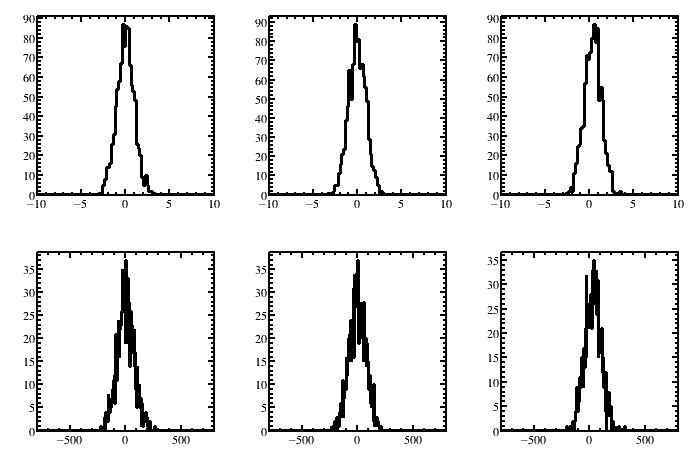

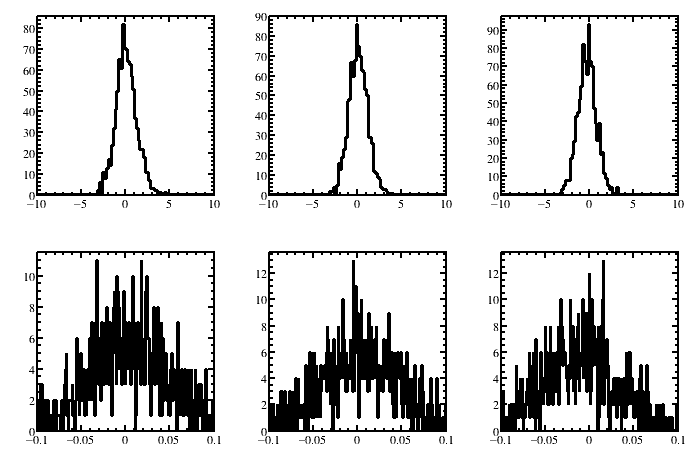

In [6]:
from ROOT import TH1F, RooRandom
pullhist = TH1F("pullhist","pulls without BDT cut",100,-10,10)
pull2hist = TH1F("pull2hist","pulls with BDT cut",100,-10,10)
pullbhist = TH1F("pullbhist","pulls with best BDT cut",100,-10,10)
reshist = TH1F("reshist","residuals without BDT cut",300,-800,800)
res2hist = TH1F("res2hist","residuals with BDT cut",300,-800,800)
resbhist = TH1F("resbhist","residuals with best BDT cut",300,-800,800)

timepullhist = TH1F("timepullhist","time pulls without BDT cut",100,-10,10)
timepull2hist = TH1F("timepull2hist","time pulls with BDT cut",100,-10,10)
timepullbhist = TH1F("timepullbhist","time pulls with best BDT cut",100,-10,10)
timereshist = TH1F("timereshist","time residuals without BDT cut",300,-0.1,0.1)
timeres2hist = TH1F("timeres2hist","time residuals with BDT cut",300,-0.1,0.1)
timeresbhist = TH1F("timeresbhist","time residuals with best BDT cut",300,-0.1,0.1)

for i in xrange(NTOYS):
    print ".",
    RooRandom.randomGenerator().SetSeed(i)
    #res,pull,timestuff = runtoy()
    res,pull,res2,pull2,resb,pullb,timestuff = runtoy()
    pullhist.Fill(pull)
    pull2hist.Fill(pull2)
    pullbhist.Fill(pullb)
    reshist.Fill(res)
    res2hist.Fill(res2)
    resbhist.Fill(resb)
    timereshist.Fill(timestuff[0]-time_central)
    timepullhist.Fill((timestuff[0]-time_central)/timestuff[1])
    timeres2hist.Fill(timestuff[2]-time_central)
    timepull2hist.Fill((timestuff[2]-time_central)/timestuff[3])
    timeresbhist.Fill(timestuff[4]-time_central)
    timepullbhist.Fill((timestuff[4]-time_central)/timestuff[5])
cc = TCanvas()
cc.Divide(3,2)
cc.cd(1)
pullhist.Draw()
cc.cd(2)
pull2hist.Draw()
cc.cd(3)
pullbhist.Draw()
cc.cd(4)
reshist.Draw()
cc.cd(5)
res2hist.Draw()
cc.cd(6)
resbhist.Draw()
cc.Draw()
ccc = TCanvas()
ccc.Divide(3,2)
ccc.cd(1)
timepullhist.Draw()
ccc.cd(2)
timepull2hist.Draw()
ccc.cd(3)
timepullbhist.Draw()
ccc.cd(4)
timereshist.Draw()
ccc.cd(5)
timeres2hist.Draw()
ccc.cd(6)
timeresbhist.Draw()
ccc.Draw()


Let's have a look. The scenario "no cut" and the scenario with the fixed cut seem unbiased. But when always picking the best cut value, on seems to be off by 12 σ!

In [7]:
print "resolution without cut is        ", reshist.GetRMS()
print "bias without cut is              ", pullhist.GetMean(), u"±", pullhist.GetMeanError()
print "resolution with cut at 0.5 is    ", res2hist.GetRMS()
print "bias with cut at 0.5 is          ", pull2hist.GetMean(), u"±", pull2hist.GetMeanError()
print "resolution with optimised cut is ", resbhist.GetRMS()
print "bias with optimised cut is       ", pullbhist.GetMean(), u"±", pullbhist.GetMeanError()


resolution without cut is         76.6792992151
bias without cut is               -0.0168266866012 ± 0.0314654641226
resolution with cut at 0.5 is     75.6238327907
bias with cut at 0.5 is           -0.0627913899116 ± 0.0311759158599
resolution with optimised cut is  73.8786644307
bias with optimised cut is        0.359303853495 ± 0.0304601344248


What happened? Well, in optimising the yield, we picked BDT cuts for which the background fluctuates upwards (in the most simple interpretation. The RooFit model does not retain information about which events are signal and which are background, but you can assume the mass spectrum to look like this. NB: If no cut value exists for which the background fluctuates up at the right position, then, well we'll just get a values for which it doesn't fluctuate down. Or maybe even the cut value which leads to the best signal significance! (We can't disentangle optimisation from fluctuation in this setup.)

The sPlot method then picks these additional background events up in the signal component, such that we have still background when using sWeights in the sFit.

And then a bit of other setups for drawings. [See this blog](http://jakevdp.github.io/blog/2013/07/10/XKCD-plots-in-matplotlib/) for more information.

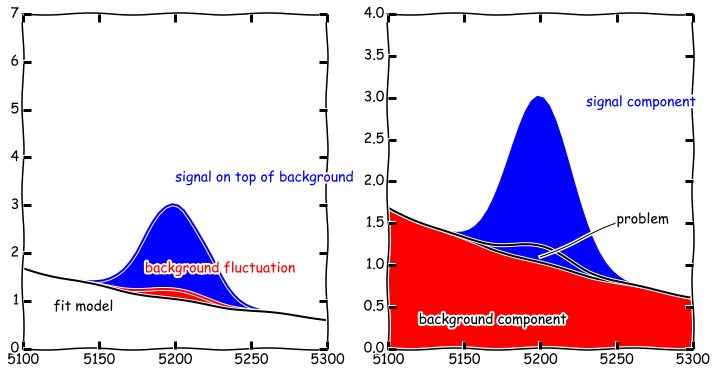

In [8]:
def signal(x):
    return 1e8*matplotlib.mlab.normpdf(x,5200,20)
def exponential(x):
    return 2e8*1000.*math.exp(-x/200.)
def background_with_fluctuation(x):
    return 0.0000001*signal(x)+exponential(x)
def both(x):
    return 0.000001*signal(x)+exponential(x)
X = linspace(5100,5300)
fig,axs = plt.subplots(1,2,figsize=(12,6),frameon=False)
ax = axs[0]
#fig = plt.figure(figsize=(8, 6))
#ax = fig.add_subplot(111)
ax.set_xlim(5100,5300)
ax.set_ylim(0, 7)
#ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%i%%'))

ax.plot(X,[both(x) for x in X],color='blue')
ax.plot(X,[background_with_fluctuation(x) for x in X],color='red')
ax.plot(X,[exponential(x) for x in X],color='black')
ax.fill_between(X,[exponential(x) for x in X],[background_with_fluctuation(x) for x in X],color='red')
ax.fill_between(X,[background_with_fluctuation(x) for x in X],[both(x) for x in X],color='blue')
ax.text(5120,0.8,"fit model",color='black')
ax.text(5180,1.6,"background fluctuation",color='red')
ax.text(5200,3.5,"signal on top of background",color='blue')

ax = axs[1]
ax.set_xlim(5100,5300)
ax.set_ylim(0, 4)
#ax.plot(X,[both(x) for x in X],color='blue')
ax.plot(X,[exponential(x) for x in X],color='black')
ax.fill_between(X,[0. for x in X],[exponential(x) for x in X],color='red')
ax.fill_between(X,[exponential(x) for x in X],[both(x) for x in X],color='blue')
ax.plot(X,[background_with_fluctuation(x) for x in X],color='black')
ax.plot([5200,5250],[1.1,1.5],'-k',lw=1,color='black')
#ax.text(5120,0.8,"fit model",color='black')
ax.text(5120,0.3,"background component",color='black')
ax.text(5230,2.9,"signal component",color='blue')
ax.text(5250,1.5,"problem",color="black")

Lets look at what happens in the sFit.

In [9]:
print "time resolution without cut is        ", timereshist.GetRMS()
print "time bias without cut is              ", timepullhist.GetMean(), u"±", timepullhist.GetMeanError()
print "time resolution with cut at 0.5 is    ", timeres2hist.GetRMS()
print "time bias with cut at 0.5 is          ", timepull2hist.GetMean(), u"±", timepull2hist.GetMeanError()
print "time resolution with optimised cut is ", timeresbhist.GetRMS()
print "time bias with optimised cut is       ", timepullbhist.GetMean(), u"±", timepullbhist.GetMeanError()


time resolution without cut is         0.0423544309185
time bias without cut is               0.0635840711404 ± 0.0368625947689
time resolution with cut at 0.5 is     0.0421297545175
time bias with cut at 0.5 is           0.0560046179058 ± 0.0342186248791
time resolution with optimised cut is  0.040771587546
time bias with optimised cut is        -0.276130456404 ± 0.0339099479906


Apparently, the sFit is not perfect. The fit w/o cut and with fixed cut have a bias of 6% of the statistical error estimate at 2σ significance. Yet, the optimised cut scenario is far worse, a 8σ significant bias of 28% of the statistical error.

### Homework

 * At the moment, the data is unlabeled. Events don't know if they are signal or background. You can add this information to the events, to see if we deal only with fluctuations in the background, or if there's something funny going on in the signal, too.
 * Related: the BDT response distribution for the signal will not be perfectly flat in any of the toys (finite statistics) does this alone introduce a bias on the sFit?
 * Can cross validation be used to fix the problem? (try!)
 * Does the bias get smaller or bigger when testing more/less possible cut values for the BDT?
 * Does an optimal cut value actually have an influence on the resolution? (